# Gridding notebook

Date: 09/24/2017  
Author: Alek Petty  
Updates: 04/20/2018 updated the description as we have ported this over to a new repo.  

Description: Notebook showing the gridding of sea ice data
Based on the grid_iceconcA.py script

Notes: 
This only grids data for one year (of your choosing). The Python script included in the same directory is set up as a loop calling a function to produce forecasts for a series of years. 



In [13]:
# Import Python libraries
%matplotlib inline

import argparse # for passing variables from bash
import sys
sys.path.append('../')
import forecast_funcs as ff
from pylab import *

from mpl_toolkits.basemap import Basemap

from scipy.interpolate import griddata

from netCDF4 import Dataset

# REPLACE THIS WITH A REPO PATH TO A MONTHLY RAW CONC DATA FILE

# File paths
datapath = '../../Data/'
rawdatapath='../../Data/'
dataoutpath='../../DataOutput/IceConcA/'
figpath='../../Figures/Arctic/IceConc/'

In [14]:
# Get map projection and create regularly spaced grid from this projection
m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l')

dx_res = 100000. # 100 km
nx = int((m.xmax-m.xmin)/dx_res)+1; ny = int((m.ymax-m.ymin)/dx_res)+1
grid_str=str(int(dx_res/1000))+'km'
lonsG, latsG, xptsG, yptsG = m.makegrid(nx, ny, returnxy=True)
#xptsG.dump(dataoutpath+'xpts'+grid_str+poleStr)
#yptsG.dump(dataoutpath+'ypts'+grid_str+poleStr)


poleStr='A'# 'A: Arctic, AA: Antarctic
month=5 # 5=June, 0=January
year=2016

# Get lon/lats pf the ice concentration data on polar sterographic grid
lats, lons = ff.get_psnlatslons(datapath)
xpts, ypts =m(lons, lats)

f = Dataset(datapath+'/OTHER/NIC_valid_ice_mask.N25km.01.1972-2007.nc', 'r')
ice_flag = f.variables['valid_ice_flag'][:]

alg=0 #0=Nasa team

if (year>2015):
    ice_conc = ff.get_month_concSN_NRT(datapath, year, month, alg=alg, pole=poleStr, monthMean=1)
    # Mask values below 0.15
    ice_conc=ma.masked_where(ice_conc<=0.15, ice_conc)
else:
    ice_conc = ff.get_month_concSN(datapath, year, month, alg=alg, pole=poleStr)

# fill ice concentration data with zeroes
ice_conc = ice_conc.filled(0)

ice_conc = where((ice_flag >=1.5), 0, ice_conc)

Num conc files: 30 in month:06


/Users/asewnath/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3416: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/asewnath/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3425: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


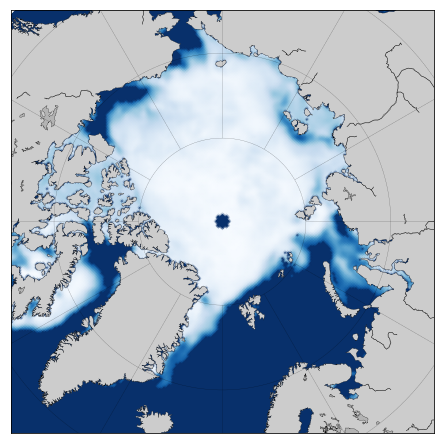

In [15]:
fig = figure(figsize=(6,6))
ax1=gca()

im1 = m.pcolormesh(xpts , ypts, ice_conc, cmap=cm.Blues_r, vmin=0, vmax=1,shading='gouraud', zorder=2)

m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
m.fillcontinents(color='0.8',lake_color='0.7', zorder=2) #This throws an error before change

subplots_adjust( right = 0.99, left = 0.01, top=0.99, bottom=0.01)
#savefig(figpath+'/Arctic_BaKa_ice_extent_map_day1.png', dpi=1000)
plt.show()

# Note the pole hole due to the incomplete satellite orbit

In [16]:
#remove half a degree as gridding around the pole hole edge
#SSMIS 89.18 -	January 2008 to present
#SSM/I Pole Hole Mask	87.2	July 1987 through December 2007
#SMMR Pole Hole Mask - 84.5	November 1978 through June 1987
if (year<1987):
    pmask=84.
elif((year==1987)&(month<=5)):
    pmask=84.
elif ((year==1987)&(month>5)):
    pmask=86.5
elif ((year>1987)&(year<2008)):
    pmask=86.5
else:
    pmask=88.5

# Grid data
ice_concG = griddata((xpts.flatten(), ypts.flatten()),ice_conc.flatten(), (xptsG, yptsG), method='linear')
ice_conc_ma=ma.masked_where(np.isnan(ice_concG), ice_concG)
ice_conc_ma=ma.masked_where((latsG>pmask), ice_conc_ma)



/Users/asewnath/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3416: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/asewnath/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3425: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


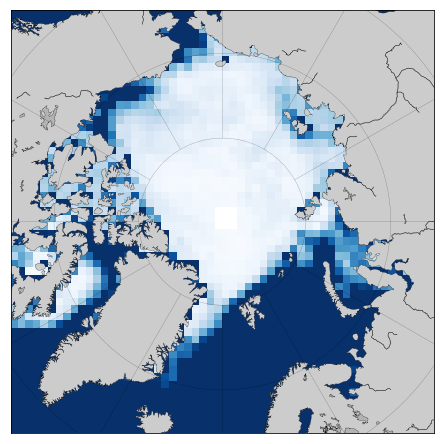

In [19]:
fig = figure(figsize=(6,6))
ax1=gca()

im1 = m.pcolormesh(xptsG , yptsG, ice_conc_ma, cmap=cm.Blues_r, vmin=0, vmax=1,shading='flat', zorder=2)

m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)
m.fillcontinents(color='0.8',lake_color='0.7', zorder=2) #This throws an error before change

subplots_adjust( right = 0.99, left = 0.01, top=0.99, bottom=0.01)
#savefig(figpath+'/Arctic_BaKa_ice_extent_map_day1.png', dpi=1000)
plt.show()